In [1]:
%matplotlib inline
from __future__ import division
import sys
if '../' not in sys.path: sys.path.append("../")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cvxpy
import numpy as np
from amnet import Variable, Linear, Constant
from amnet import atoms, lyap
import amnet
from amnet.util import mfp
import z3
# set up global z3 parameters
# parameters from https://stackoverflow.com/a/12516269
z3.set_param('auto_config', False)
z3.set_param('smt.case_split', 5)
z3.set_param('smt.relevancy', 2)



In [ ]:
# 1-D dynamics for an agent with mass m

def fn_dynamics(x,u,T,m):
    A = np.array([[1,T],[0,1]])
    #A = np.array([[1,-1],[-0.4,1]])
    B = np.array([[T**2/2/m], [T/m]])
    f = A*x+B*u
    return f
   
Mass = 1
n = 2
m = 1
T = 15
t_total = 7.5
dt = float(t_total)/float(T)
u_sat = 1/float(t_total)
u_min = 0.2/float(t_total)
xinit = np.array([[0],[0]])
xfinal= np.array([[1],[0]])

In [ ]:
# Solution via CVXPy
xc = []
uc = []
for t in xrange(T):
    xc.append(cvxpy.Variable(n))
    uc.append(cvxpy.Variable(m))

cons = []
cons.append(xc[0]==xinit)
cons.append(xc[-1]==xfinal)
sum_con = 0

for t in xrange(T-1):
    cons.append(xc[t+1] == fn_dynamics(xc[t],uc[t],dt,Mass))
    cons.append(cvxpy.abs(uc[t]) <= u_sat)
    #cons.append(cvxpy.abs(uc[t]) >= u_min)
    sum_con += cvxpy.norm1(uc[t])
sum_con += cvxpy.norm1(uc[T-1])
obj = cvxpy.Minimize(sum_con)
prob_cvx = cvxpy.Problem(obj,cons)
result = prob_cvx.solve()
print result
print xc[0].value, xc[-1].value

In [ ]:
xvc = []
uvc = []
for t in xrange(T):
    xvc.append(np.array(xc[t].value))
    uvc.append(uc[t].value)

    
x1plot,x2plot = zip(*xvc)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(x1plot,x2plot,'x-b')
#ax[0].plot(x1cplot,x2cplot,'x-r')
ax[0].set_title('System trajectory')
ax[0].set_xlim(xinit[0],xfinal[0])
ax[0].set_ylim(-0.5,0.5)
ax[0].set_xlabel('$\dot{x}$')
ax[0].set_ylabel('$x$')
uplot = uvc
ax[1].plot(np.linspace(0,t_total,num=T),np.array(uplot).T,'xr')
ax[1].set_xlim(0,t_total)
ax[1].set_ylim(-u_sat-0.1*u_sat,u_sat+0.1*u_sat)
ax[1].set_title('Applied control $u(t)$')
#ax[1].set_ylabel('$\|u(t)\|_1$')
ax[1].set_xlabel('Time $(s)$')
plt.show()
fig.savefig('1D-CVX.eps',format='eps')

In [ ]:
# Solution via AMNET

x_cont = Variable(outdim=T*(n+m),name='XCont')
x = []
u = []
for t in xrange(T):
    x.append(x_cont[t*(n+m)+0:t*(n+m)+n])
    u.append(x_cont[t*(n+m)+n:t*(n+m)+n+m])
    assert len(x[t]) == n and len(u[t])==m
    
x_init = Constant(x[0],xinit)
x_final = Constant(x[T-1],xfinal)

obj = amnet.opt.Minimize(amnet.atoms.norm1(amnet.atoms.from_list(u)))
cons = []
cons.append(x[0] == x_init)
for t in xrange(T-1):
    cons.append(x[t+1] == fn_dynamics(x[t],u[t],dt,Mass))
    cons.append(amnet.atoms.norminf(u[t]) <= u_sat)
    cons.append(amnet.atoms.norminf(u[t]) >= u_min)
cons.append(amnet.atoms.norminf(u[T-1]) <= u_sat)
cons.append(amnet.atoms.norminf(u[T-1]) >= u_min)
cons.append(x[T-1] == x_final)
Opts = amnet.opt.OptOptions()
Opts.fptol = float(2**-1)
prob = amnet.opt.Problem(obj,cons,options=Opts)
result = prob.solve()

In [ ]:
# Plotting for amnet results
xv = []
uv = []
xvc = []
uvc = []
for t in xrange(T):
    xv.append(x[t].eval(result.value))
    uv.append(u[t].eval(resul\||_1t.value))

    
x1plot,x2plot = zip(*xv)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(x1plot,x2plot,'x-b')
#ax[0].plot(x1cplot,x2cplot,'x-r')
ax[0].set_title('System trajectory')
ax[0].set_xlim(xinit[0],xfinal[0])
ax[0].set_ylim(-0.5,0.5)
ax[0].set_xlabel('$\dot{x}$')
ax[0].set_ylabel('$x$')
uplot = zip(*uv)
ax[1].plot(np.linspace(0,t_total,num=T),np.array(uplot).T,'xr')
ax[1].set_xlim(0,t_total)
ax[1].set_ylim(-u_sat-0.01*u_sat,u_sat+0.01*u_sat)
ax[1].set_title('Applied control $u(t)$')
#ax[1].set_ylabel('$\|u(t)\|_1$')
ax[1].set_xlabel('Time $(s)$')
plt.show()
fig.savefig('1D-AMN.eps',format='eps')

In [2]:
# 3-D spacecraft dynamics

def D3_dynamics(x,u,T,M):
    #assert len(x)==6
    g = np.array([[0,0,0,0,-3.71*T,0]]).T #np.array([[0,0,0,0,0,0]]).T
    A = np.block([[np.eye(3)*T,np.eye(3)*T],[np.zeros((3,3)),np.eye(3)*T]])
    B = np.block([[np.eye(3)*T**2/2/M],[np.eye(3)*(T/M)]])
    f = A*x+B*u #+g
    return f
   
Mass = 1
n = 6
m = 3
T = 10
t_total = 10
dt = float(t_total)/float(T)
print dt,T
u_sat = 100*dt
u_min = 20*dt
xinit = np.array([[400],[400],[300],[-10],[-10],[-75]])
xfinal= np.zeros(shape=(n,1))


1.0 10


In [3]:
# Solution via CVXPy
xc = []
uc = []
for t in xrange(T):
    xc.append(cvxpy.Variable(n))
    uc.append(cvxpy.Variable(m))

cons = []
cons.append(xc[0]==xinit)
cons.append(xc[-1]==xfinal)
sum_con = 0

for t in xrange(T-1):
    cons.append(xc[t+1] == D3_dynamics(xc[t],uc[t],dt,Mass))
    cons.append(cvxpy.abs(uc[t]) <= u_sat)
    cons.append(xc[t][0]-xc[t][1]==0)
    #cons.append(cvxpy.abs(uc[t]) >= u_min)
    sum_con += cvxpy.norm1(uc[t])
sum_con += cvxpy.norm1(uc[T-1])
obj = cvxpy.Minimize(sum_con)
prob_cvx = cvxpy.Problem(obj,cons)
result = prob_cvx.solve()
print result
print xc[-1].value

252.500000004
[[ -5.80123854e-16]
 [  4.46601078e-16]
 [  6.57937351e-17]
 [  5.84014770e-16]
 [  7.06522175e-17]
 [ -8.00751111e-16]]


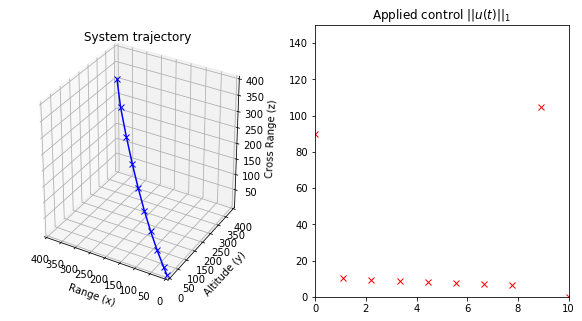

In [4]:
xvc = []
uvc = []
for t in xrange(T):
    xvc.append(np.array(xc[t].value))
    uvc.append(np.linalg.norm(uc[t].value,1))

    
x1plot,y1plot,z1plot,x2plot,y2plot,z2plot = zip(*xvc)
#print np.array(x1plot)
#print np.array(y1plot)
fig2 , ax10 = plt.subplots(1,2,figsize=(10,5))
ax1 = plt.subplot(121,projection="3d")
ax1.plot(np.array(x1plot),np.array(z1plot),'x-b',zs=y1plot,zdir='x')
#ax[0].plot(x1cplot,x2cplot,'x-r')
ax1.set_title('System trajectory')
ax1.set_xlim(xinit[0],xfinal[0])
ax1.set_ylim(xfinal[1],xinit[1])
ax1.set_xlabel('Range (x)')
ax1.set_ylabel('Altitude (y)')
ax1.set_zlabel('Cross Range (z)')
uplot = uvc
ax2 = plt.subplot(122)
ax2.plot(np.linspace(0,t_total,num=T),np.array(uplot).T,'xr')
ax2.set_xlim(0,t_total)
ax2.set_ylim(0,150)#-u_sat-0.1*u_sat,u_sat+0.1*u_sat)
ax2.set_title('Applied control $\||u(t)\||_1$')
plt.show()
fig2.savefig('3D-CVX.eps',format='eps')

In [ ]:
# AMNET solution
x_cont = Variable(outdim=T*(n+m),name='XCont')
print T*(n+m)
x = []
u = []
objsum = 0
for t in xrange(T):
    x.append(x_cont[t*(n+m)+0:t*(n+m)+n])
    u.append(x_cont[t*(n+m)+n:t*(n+m)+n+m])
    objsum += amnet.atoms.norm1(u[t])
    assert len(x[t]) == n and len(u[t])==m
    
x_init = Constant(x[0],xinit)
x_final = Constant(x[T-1],xfinal)
#import pdb; pdb.set_trace()

obj = amnet.opt.Minimize(objsum)
cons = []
cons.append(x[0] == x_init)
for t in xrange(T-1):
    cons.append(x[t+1] == D3_dynamics(x[t],u[t],dt,Mass))
    cons.append(amnet.atoms.norminf(u[t]) <= u_sat)
    cons.append(x[t][0]-x[t][1]==0)
    cons.append(amnet.atoms.norm1(u[t]) >= u_min)
cons.append(amnet.atoms.norminf(u[T-1]) <= u_sat)
cons.append(amnet.atoms.norm1(u[T-1]) >= u_min)
cons.append(x[T-1] == x_final)
Opts = amnet.opt.OptOptions()
Opts.fptol = float(2**-1)
prob = amnet.opt.Problem(obj,cons,options=Opts)
result = prob.solve()

90

itr | lo          | hi          | gam         | res   | obj         | feas        
  1 | -1.0486e+06 |  1.0486e+06 |           0 | unsat | None        | False 
  2 |           0 |  1.0486e+06 |  5.2429e+05 | sat   |      611.75 | False 
  3 |           0 |  5.2429e+05 |  2.6214e+05 | sat   |      611.75 | False 
  4 |           0 |  2.6214e+05 |  1.3107e+05 | sat   |      588.58 | False 
  5 |           0 |  1.3107e+05 |       65536 | sat   |      588.58 | False 
  6 |           0 |       65536 |       32768 | sat   |      584.89 | False 
  7 |           0 |       32768 |       16384 | sat   |      584.89 | False 
  8 |           0 |       16384 |        8192 | sat   |      584.89 | False 
  9 |           0 |        8192 |        4096 | sat   |      584.89 | False 
 10 |           0 |        4096 |        2048 | sat   |      584.89 | False 
 11 |           0 |        2048 |        1024 | sat   |      583.64 | False 
 12 |           0 |        1024 |         512 | sat   |         51

In [ ]:
# Plotting for amnet results
xv = []
uv = []
xvc = []
uvc = []
for t in xrange(T):
    xv.append(x[t].eval(result.value))
    uv.append(np.linalg.norm(u[t].eval(result.value),1))

x1plot,y1plot,z1plot,x2plot,y2plot,z2plot = zip(*xv)
#print np.array(x1plot)
#print np.array(y1plot)
fig2 , ax10 = plt.subplots(1,2,figsize=(10,5))
ax1 = plt.subplot(121,projection="3d")
ax1.plot(np.array(x1plot),np.array(z1plot),'x-b',zs=y1plot,zdir='x')
#ax[0].plot(x1cplot,x2cplot,'x-r')
ax1.set_title('System trajectory')
ax1.set_xlim(xinit[0],xfinal[0])
ax1.set_ylim(xfinal[1],xinit[1])
ax1.set_xlabel('Range (x)')
ax1.set_ylabel('Altitude (y)')
ax1.set_zlabel('Cross Range (z)')
uplot = uv
ax2 = plt.subplot(122)
ax2.plot(np.linspace(0,t_total,num=T),np.array(uplot).T,'xr')
ax2.set_xlim(0,t_total)
ax2.set_ylim(0,150)#-u_sat-0.1*u_sat,u_sat+0.1*u_sat)
ax2.set_title('Applied control $\||u(t)\||_1$')
ax2.set_xlabel('Time (s)')
plt.show()
fig2.savefig('3D-AMN.eps',format='eps')
    